<a href="https://colab.research.google.com/github/alecorlo1314/prediccion-calificacion-estudiante/blob/main/Calificacion_de_Estudiante.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introducción y objetivos

Prediccion de las notas para un estudiante segun:
* `Horas diarias de estudio`
* `Porcentaje de asistencia a clase`
* `Duración y calidad del sueño`
* `Disponibilidad de internet`
* `Método de estudio`
* `Valoración de la instalación institucional`
* `Nivel de dificultad del examen.`

Estos factores reflejan un amplio espectro de influencias comúnmente observadas en entornos educativos. La puntuación del examen (0–100) se obtiene mediante una fórmula ponderada que imita patrones de rendimiento académico reales.

# Librerias

In [339]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import mutual_info_regression, SelectKBest, chi2,RFE

# Importacion de Datos

In [273]:
ruta = "/content/drive/MyDrive/MACHINE LEARNING/ML SUPERVISADA /REGRESION/Calificacion/Exam_Score_Prediction.csv"
datos = pd.read_csv(ruta)

# Exploración inicial de datos (EDA)

## Estadísticas descriptivas

In [274]:
#Verificacion de datos
datos.head()

,student_id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,1,17,male,diploma,2.78,92.9,yes,7.4,poor,coaching,low,hard,58.9
1,2,23,other,bca,3.37,64.8,yes,4.6,average,online videos,medium,moderate,54.8
2,3,22,male,b.sc,7.88,76.8,yes,8.5,poor,coaching,high,moderate,90.3
3,4,20,other,diploma,0.67,48.4,yes,5.8,average,online videos,low,moderate,29.7
4,5,20,female,diploma,0.89,71.6,yes,9.8,poor,coaching,low,moderate,43.7


In [275]:
#Eliminamos la columna student_id
datos.drop('student_id', axis=1, inplace=True)

In [276]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               20000 non-null  int64  
 1   gender            20000 non-null  object 
 2   course            20000 non-null  object 
 3   study_hours       20000 non-null  float64
 4   class_attendance  20000 non-null  float64
 5   internet_access   20000 non-null  object 
 6   sleep_hours       20000 non-null  float64
 7   sleep_quality     20000 non-null  object 
 8   study_method      20000 non-null  object 
 9   facility_rating   20000 non-null  object 
 10  exam_difficulty   20000 non-null  object 
 11  exam_score        20000 non-null  float64
dtypes: float64(4), int64(1), object(7)
memory usage: 1.8+ MB


In [277]:
#Categorias conteo
col_cat = datos.select_dtypes(include='object').columns
for col in col_cat:
    print(col)
    print(datos[f'{col}'].unique())
    print('*'*75)

gender
['male' 'other' 'female']
***************************************************************************
course
['diploma' 'bca' 'b.sc' 'b.tech' 'bba' 'ba' 'b.com']
***************************************************************************
internet_access
['yes' 'no']
***************************************************************************
sleep_quality
['poor' 'average' 'good']
***************************************************************************
study_method
['coaching' 'online videos' 'mixed' 'self-study' 'group study']
***************************************************************************
facility_rating
['low' 'medium' 'high']
***************************************************************************
exam_difficulty
['hard' 'moderate' 'easy']
***************************************************************************


**Observaciones**

Columnas Numericas:
* student_id
* age
* study_hours
* class_attendance
* sleep_hours
* exam_score

Columnas Categoricas:
* gender
* course
* internet_access
* sleep_quality
* study_method
* facility_rating
* exam_difficulty

In [278]:
#Informacion Estadistica
datos.describe()

,age,study_hours,class_attendance,sleep_hours,exam_score
count,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000
mean,20.473300,4.007604,70.017365,7.00856,62.513225
std,2.284458,2.308313,17.282262,1.73209,18.908491
min,17.000000,0.080000,40.600000,4.10000,19.599000
25%,18.000000,2.000000,55.100000,5.50000,48.800000
50%,20.000000,4.040000,69.900000,7.00000,62.600000
75%,22.000000,6.000000,85.000000,8.50000,76.300000
max,24.000000,7.910000,99.400000,9.90000,100.000000


**Observaciones**

* `student_id:` Es un identificador único para cada estudiante, con un rango de 1 a 20001. No es una variable que aporte información estadística sobre el comportamiento.
* `age (edad):` La edad de los estudiantes varía entre **17 y 24 años**. **La edad promedio** es de aproximadamente **20.47 años**, con una **desviación estándar baja (2.28)**, lo que sugiere que la mayoría de los estudiantes están en un rango de edad similar y relativamente joven.
* `study_hours (horas de estudio):`Los estudiantes dedican entre 0.08 y 7.91 horas al estudio.
El promedio de horas de estudio es de alrededor de 4.01 horas diarias, con una desviación estándar de 2.31, lo que indica una variabilidad significativa en los hábitos de estudio.
* `class_attendance (asistencia a clase):`La asistencia varía desde un 40.6% hasta un 99.4%.
El promedio de asistencia es del 70.02%, con una desviación estándar de 17.28%, lo que muestra una dispersión considerable en la asistencia de los estudiantes.
* `sleep_hours (horas de sueño):` Los estudiantes duermen entre 4.1 y 9.9 horas.
El promedio de horas de sueño es de 7.01 horas, con una desviación estándar de 1.73 horas, lo que indica una distribución moderada en la duración del sueño.
* `exam_score (puntuación del examen):`Las puntuaciones de los exámenes oscilan entre 19.599 y 100.
La puntuación promedio es de 62.51, con una desviación estándar de 18.91, lo que sugiere una amplia gama de rendimientos en los exámenes, desde muy bajos hasta perfectos.

## Distribucion Numerica

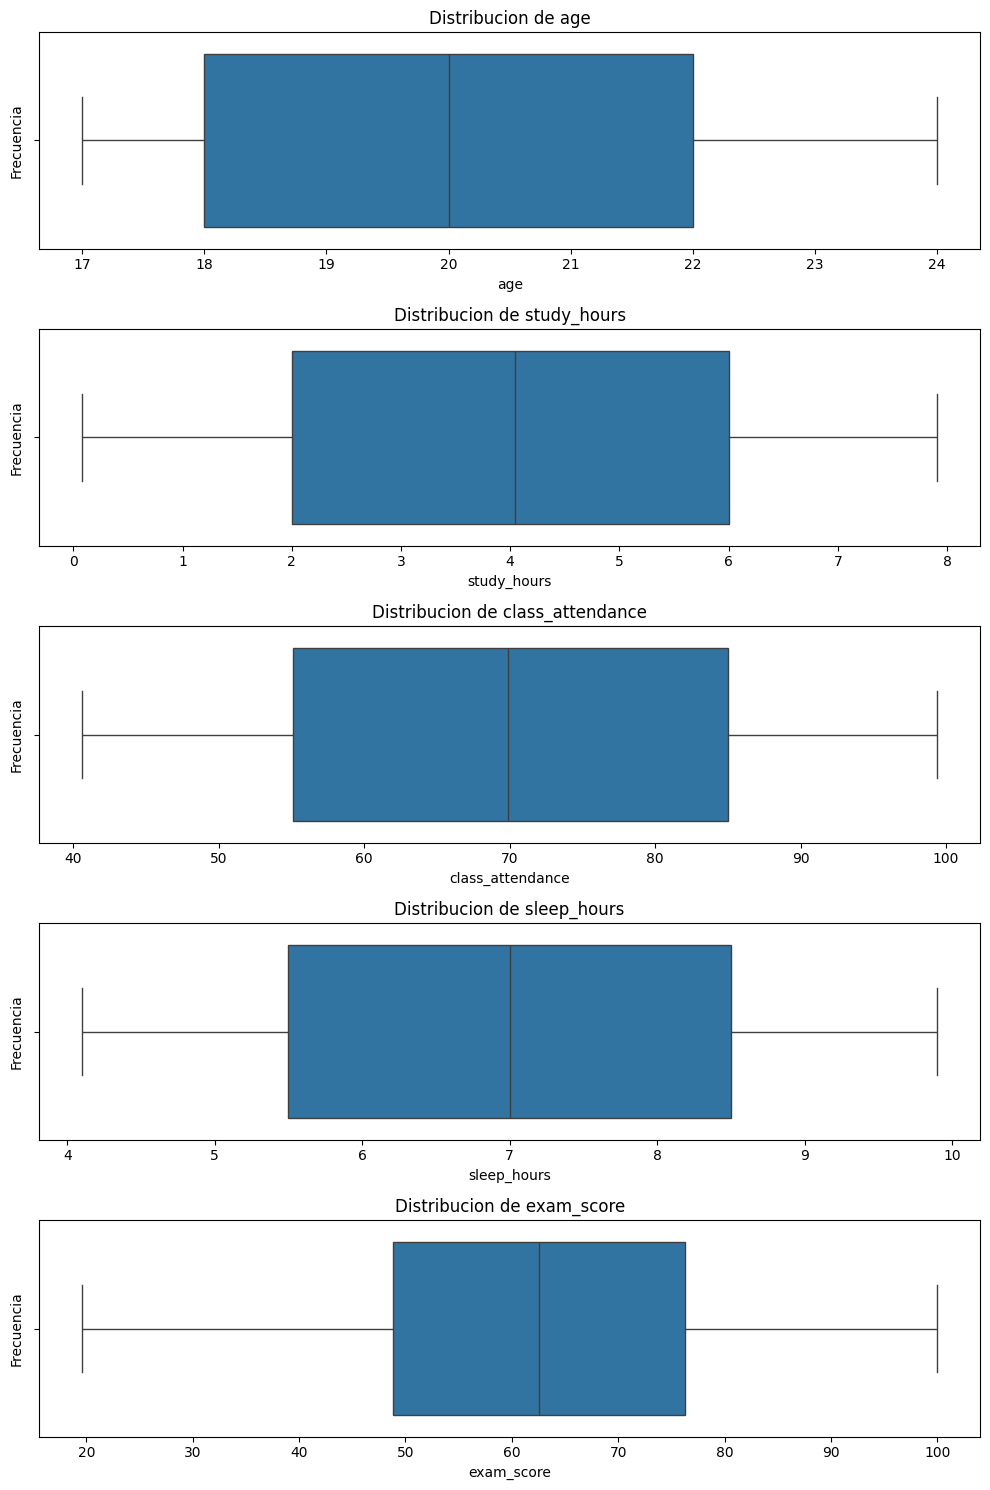

In [279]:
cols_num = ['age', 'study_hours', 'class_attendance', 'sleep_hours','exam_score']
#Distribucion con boxplot
fig, ax = plt.subplots(len(cols_num),1 , figsize=(10,15))
for i, col in enumerate(cols_num):
  sns.boxplot(x=col, data=datos, ax=ax[i])
  ax[i].set_xlabel(col)
  ax[i].set_ylabel('Frecuencia')
  ax[i].set_title(f'Distribucion de {col}')
plt.tight_layout()
plt.show()

**Observaciones**

No se observan outliners, por lo que suguiere un buen balance de los datos.

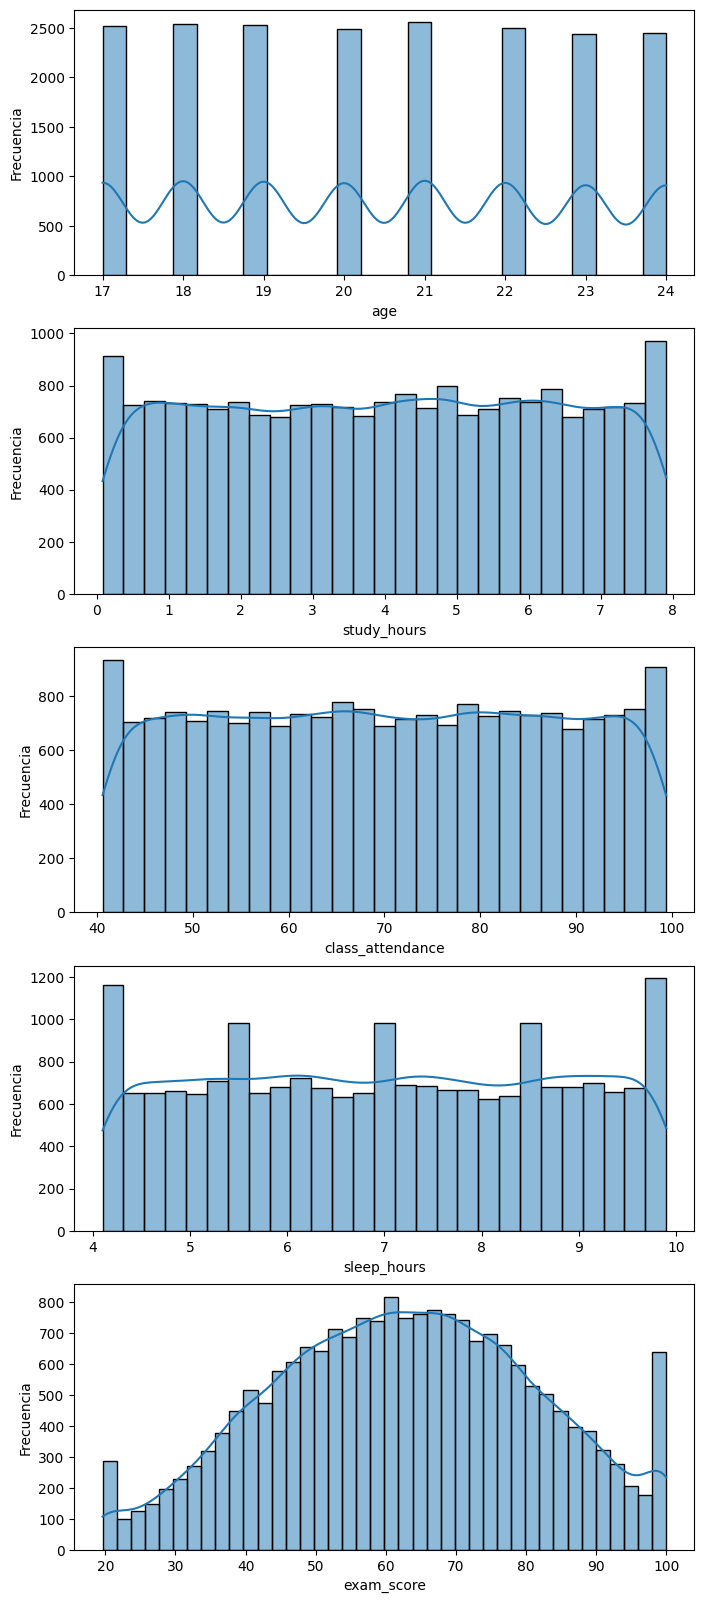

In [280]:
fig, ax = plt.subplots(len(cols_num),1 , figsize=(8, 20))
for i, col in enumerate(cols_num):
  if col == 'edad':
    sns.histplot(x=col, data=datos, ax=ax[i], kde=True, bins=8)
  else:
    sns.histplot(x=col, data=datos, ax=ax[i], kde=True)
    ax[i].set_xlabel(col)
    ax[i].set_ylabel('Frecuencia')
plt.show()

**Observaciones**

Los datos estan bien distribuidos

Correlacion

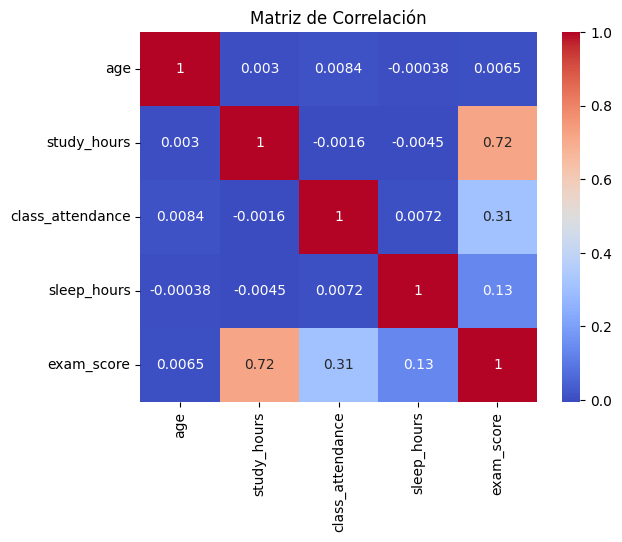

In [281]:
matriz_correlacion = datos.corr(numeric_only=True)
sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

**Observaciones**
* Correlacion alta: La variable study_hours tiene una correlacion bastante alta y algo coerente. Ademas, class_attendance y sleep_hours tiene un poco de correlacion.

* Cercanía a cero: La variable age no tiene un correlacion lineal.

Esto sugiere que, al menos en términos de relaciones lineales, las horas de estudio, la asistencia a clase, las horas de sueño nos ayudan a ver que entre mas aumente la nota es muy posible que estas variables ayuden a definir la prediccion.Ademas, es posible que otros factores (como las variables categóricas) o relaciones no lineales sean de gran ayuda para aumentar la precision.

## Distribuicion Categoria

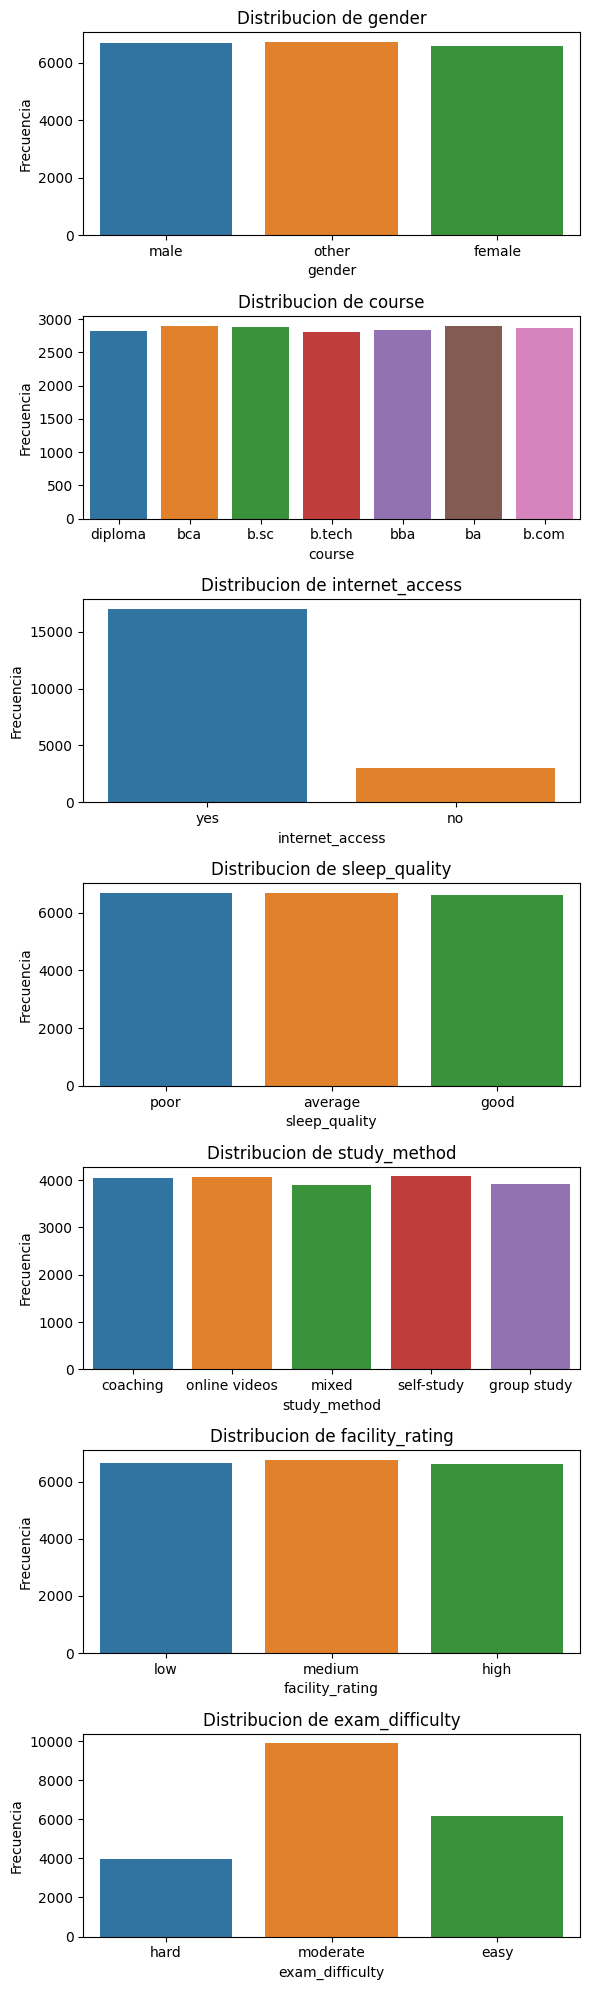

In [282]:
col_cat = datos.select_dtypes(include='object').columns
fig, ax = plt.subplots(len(col_cat),1 , figsize=(6,20))
for i, col in enumerate(col_cat):
  sns.countplot(x=col, data=datos, ax=ax[i], hue=col)
  ax[i].set_xlabel(col)
  ax[i].set_ylabel('Frecuencia')
  ax[i].set_title(f'Distribucion de {col}')
plt.tight_layout()
plt.show()

**Observaciones**

* El acceso al internet esta **desbalanceado** "Yes" tiene casi 5 veces mas que "No" por lo que un modelo podria darle mas importancia al "Yes".
* El dificultad del examen se centra mas en moderada, luego facil y ultimo dificil.

# Preprocesamiento

### Seleccion de Caracteristicas

In [487]:
#Seleccion de las variables a utilizar
X = datos[['gender', 'course','internet_access', 'sleep_quality', 'study_method','facility_rating', 'exam_difficulty','age', 'study_hours', 'class_attendance', 'sleep_hours']]
y = datos['exam_score']

## Division de Datos

In [488]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Preprocesamiento ColumnTransformer

In [489]:
#Columnas
col_cat_nom = ['gender', 'course', 'study_method']
col_cat_or = ['sleep_quality','facility_rating','exam_difficulty']
col_cat_bin = ['internet_access']
col_num = ['age', 'study_hours', 'class_attendance', 'sleep_hours']

proprocessor = ColumnTransformer(
    transformers=[
        ('cat_nom', OneHotEncoder(handle_unknown='ignore'), col_cat_nom),
        ('cat_or', OrdinalEncoder(), col_cat_or),
        ('cat_bin', OrdinalEncoder(), col_cat_bin),
        ('num', StandardScaler(), col_num)
    ]
)

## Pipeline

In [501]:
#RFE o Recursive Feature Eliminator se utiliza para la eliminacion de caracteristicas reduntantes y que no aportan mucho al modelo
selector = RFE(estimator=RandomForestRegressor(), n_features_to_select=7)

pipeline = Pipeline([
    ('prep', proprocessor),
     ('select', selector),
      ('model', RandomForestRegressor(n_estimators = 100,
                                      max_samples=2/3))
      ])

pipeline.fit(X, y)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat_nom',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender', 'course',
                                                   'study_method']),
                                                 ('cat_or', OrdinalEncoder(),
                                                  ['sleep_quality',
                                                   'facility_rating',
                                                   'exam_difficulty']),
                                                 ('cat_bin', OrdinalEncoder(),
                                                  ['internet_access']),
                                                 ('num', StandardScaler(),
                                                  ['age', 'study_hours',
                                                   'class_attendance',
                                                   'sleep_hours'])])),
                ('select',
                 RFE(estimator=RandomForestRegressor(),
                     n_features_to_select=7)),
                ('model',
                 RandomForestRegressor(max_samples=0.6666666666666666))])

## Muestra de las mejores caracteristicas segun RFE

In [505]:
# Acceder al paso de preprocesamiento
preprocessor = pipeline.named_steps['prep']
# Obtener nombres de las columnas transformadas
feature_names = preprocessor.get_feature_names_out()

# Acceder al paso RFE
rfe_step = pipeline.named_steps['select']

# Filtrar las seleccionadas
selected_features = feature_names[rfe_step.support_]
print("Features seleccionadas:", selected_features)

Features seleccionadas: ['cat_nom__study_method_coaching' 'cat_or__sleep_quality'
 'cat_or__facility_rating' 'num__age' 'num__study_hours'
 'num__class_attendance' 'num__sleep_hours']


## Prediccion

In [506]:
y_pred = pipeline.predict(X_test)

##Evaluacion

In [509]:
print(f'R2 Score: {r2_score(y_test, y_pred)}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')

R2 Score: 0.91657785200794
RMSE: 5.462586709332161


##Visualizacion

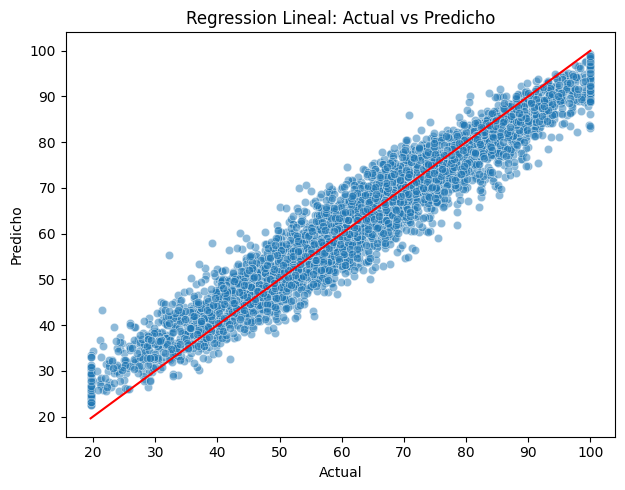

In [510]:
# Crear GRAFICO
plt.figure(figsize=(12,5))

plt.subplot(1,2,2)
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='-')
plt.title("Regression Lineal: Actual vs Predicho")
plt.xlabel("Actual")
plt.ylabel("Predicho")
# Show plots.
plt.tight_layout()
plt.show()

# Conclusiones

### **Datos predichos**

El modelo predice la calificación de examen de los estudiantes a partir de variables como:

* Genero (gender)
* Course (course)
* Acceso al internet (internet_access)
* Calidad del sueño (sleep_quality)
* Metodo de Estudio (study_method)
* Clasificación de la instalación (facility_rating)
* Dificultad del examen (exam_difficulty)
* Edad (Age)
* Asistencia a clase (class_attendance)
* Horas de sueño (sleep_hours)
* Horas de estudio (study_hours)

Tras la selección de características con RFE, las variables más relevantes fueron:
`study_method, sleep_quality, facility_rating, age, study_hours, class_attendance y sleep_hours`

### **Métricas de desempeño**
**Coeficiente de determinación (R²):**
`0.92 →` el modelo explica un 92% de la variabilidad en las notas.

**Resumen**: Esto significa que el modelo es altamente capaz de capturar los patrones reales.

**Error cuadrático medio (RMSE):**
`5.46 →` el error promedio bajó casi a la mitad.

**Resumen:** Las predicciones son mucho más precisas y consistentes.